In [21]:
import copy

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from scipy.signal import savgol_filter
import os as os

path = "./results/"

The load_curves function loads the results of multiple algorithms across different environments from .npy files, stores them in a dictionary structure, and processes them to ensure the curves all have the same length.

In [22]:
def load_curves(algorithms, envs, t):
    curves = {alg: {e: [] for e in envs} for alg in algorithms} # create a dictionary 
    for alg in algorithms:
        for e in envs:
            for i in range(0, 100):
                if t == 0: name = f"{path}/{alg}_{e}_{i}.npy"
                if t == 1: name = f"{path}/{alg}_{e}_{i}_s.npy"
                
                if os.path.isfile(name):
                    #print(f"{name} loaded", np.load(name).shape)
                    curves[alg][e].append(list(np.load(name)))
            max_size = -1        
            for i in range(len(curves[alg][e])):
                if len(curves[alg][e][i]) > max_size:
                    max_size = len(curves[alg][e][i])
            for i in range(len(curves[alg][e])):
                while len(curves[alg][e][i]) <= max_size:
                    curves[alg][e][i].append(curves[alg][e][i][-1])

            curves[alg][e] = np.array(curves[alg][e]) if len(curves[alg][e]) else np.array([[]])
    
    return curves

The smooth function applies a smoothing technique to the loaded data by averaging over a window of neighboring points, creating a more visually appealing curve by reducing fluctuations.

In [23]:
def smooth(data, length=10):
    data = data.copy()
    pad = copy.deepcopy(data[:, -1, None].repeat(length-1, axis=-1)) # padding the data
    pad_data = np.concatenate((data, pad), axis=-1)
    pad = copy.deepcopy(data[:, 0, None].repeat(length-1, axis=-1))  # padding the data
    pad_data = np.concatenate((pad, pad_data), axis=-1)
    
    for i in range(length, len(data[0])+length):
        assert i-length >= 0
        data[:, i-length] = np.mean(pad_data[:, i-length:i+length], axis=-1) # smooth the data with its average
    return data

Plot the results

In [24]:
def plot_results(ENVS, ALGORITHMS, curves, use_median, sample_rates):
    """
    Plots the performance curves for different algorithms in various environments.
    Parameters:
    - ENVS: List of environment names.
    - ALGORITHMS: List of algorithm names.
    - curves: Dictionary of data for each algorithm and environment.
    - use_median: Boolean; if True, use median with quartiles; if False, use mean with std deviation.
    - sample_rates: Dictionary of sampling rates for each algorithm.
    """
    for e in ENVS:
        fig, ax = plt.subplots(1, 1, figsize=(10, 5))
        ax.set_title(e) # Set environment name as the title
        ax.set_xlabel("Time [hours]") # Label for x-axis in hours
        ax.set_xlabel("Steps [1e4]") # Label for x-axis in steps
        ax.set_ylabel("Success rate" if use_median else "Reward") # Label for y-axis
        
        for i, alg in enumerate(ALGORITHMS):
            c = curves[alg][e] # Get data for the algorithm on this environment
            if c.size == 0:
                print(f"No data for {alg} on {e}. Skipping.")
                continue # Skip if there's no data
            
            # Compute the time axis based on the sampling rate
            x = np.arange(c.shape[1]) / sample_rates[alg]   # for hours
            x = np.arange(c.shape[1]) / 2                   # for steps
            
            if use_median:
                # Compute median, 1st quartile (25th percentile), and 3rd quartile (75th percentile)
                median = smooth(np.median(c, axis=0, keepdims=True), length=2).squeeze() # Smooth median
                q1 = smooth(np.percentile(c, 25, axis=0, keepdims=True), length=2).squeeze() # Smooth 25th percentile
                q3 = smooth(np.percentile(c, 75, axis=0, keepdims=True), length=2).squeeze() # Smooth 75th percentile
                ax.plot(x, median, label=alg, linewidth=4, linestyle='-', color='C' + str(i)) # Plot median curve
                ax.fill_between(x, q1, q3, alpha=0.2, color='C' + str(i)) # Fill between 1st and 3rd quartile
            else:
                # Compute mean and standard deviation
                mu = smooth(c.mean(axis=0, keepdims=True), length=2).squeeze() # Smooth mean
                sigma = smooth(c.std(axis=0, keepdims=True), length=2).squeeze() # Smooth std deviation
                ax.plot(x, mu, label=alg, linewidth=4, linestyle='-', color='C' + str(i)) # Plot mean curve
                ax.fill_between(x, mu + sigma, mu - sigma, alpha=0.2, color='C' + str(i)) # Fill between std deviation
        
            ax.set_xticks(np.arange(0, x[-1] + 1, step=1))      # for hours
            ax.set_xticks(np.arange(0, x[-1] + 1, step=10))     # for steps

        ax.grid(True)   # Add grid
        ax.legend()     # Add legend for algorithms
        # ax.set_xlim(0, 10)
        plt.show() # Show the plot

In [25]:
# Define environments and algorithms
ENVS = ['MR-env']
ALGORITHMS = ['OurDDPG', 'ExpD3', 'TD3', 'SAC']

sample_rates = {
    "OurDDPG": 10,  # 10 Hz
    "ExpD3": 15,    # 15 Hz
    "TD3": 8,       # 8 Hz
    "SAC": 5,       # 5 Hz
}

# ENVS = ['MR-env', 'MR-corridor-env']
# ALGORITHMS = ['OurDDPG', 'ExpD3', 'SAC']

Plots the performance curves for each algorithm on each environment.

No data for OurDDPG on MR-env. Skipping.
No data for ExpD3 on MR-env. Skipping.
No data for TD3 on MR-env. Skipping.
No data for SAC on MR-env. Skipping.


/tmp/ipykernel_18726/1552156961.py:46: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()     # Add legend for algorithms


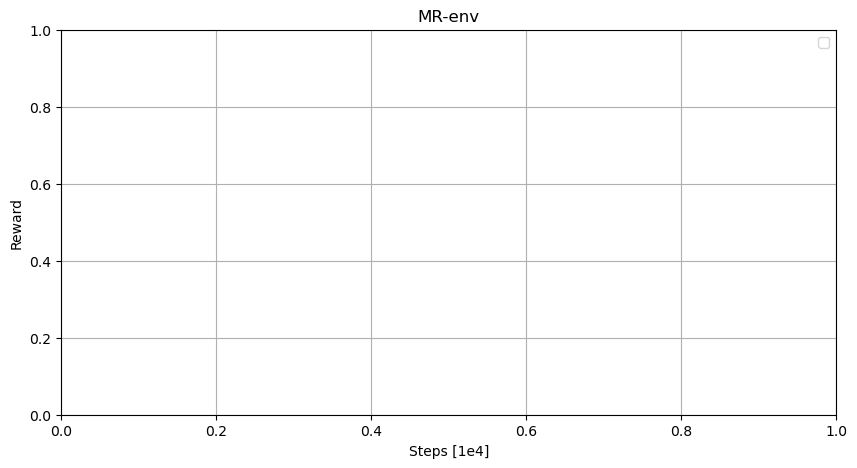

In [26]:
# Load the curves
curves = load_curves(ALGORITHMS, ENVS, t = 0)
# Plot data
plot_results(ENVS, ALGORITHMS, curves, False, sample_rates)

No data for OurDDPG on MR-env. Skipping.
No data for ExpD3 on MR-env. Skipping.
No data for TD3 on MR-env. Skipping.
No data for SAC on MR-env. Skipping.


/tmp/ipykernel_18726/1552156961.py:46: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()     # Add legend for algorithms


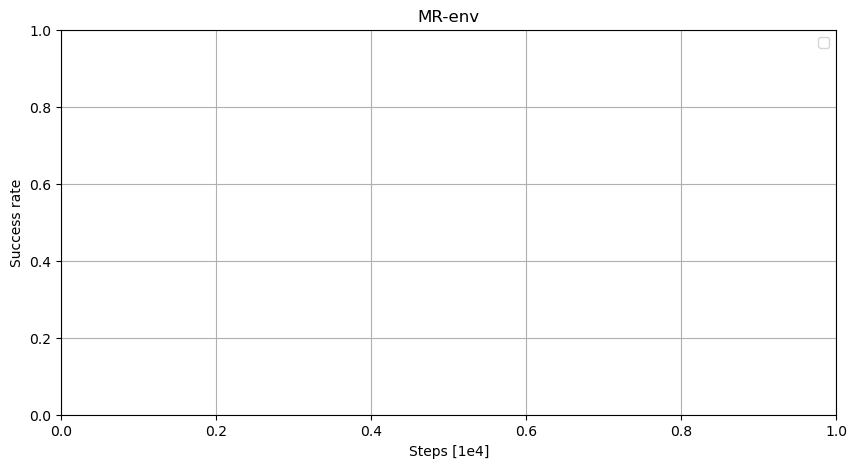

In [27]:
# Load the curves
curves = load_curves(ALGORITHMS, ENVS, t = 1)
# Plot data
plot_results(ENVS, ALGORITHMS, curves, True, sample_rates)

In [28]:
import glob

def calculate_mean_success_rate(file_pattern):
    # List all files that match the naming pattern
    file_paths = glob.glob(file_pattern)
    
    # Check if any files were found
    if not file_paths:
        print("No files found matching the pattern.")
        return None
    
    # Load each file and store the results in a list
    data = []
    for file_path in file_paths:
        s = np.load(file_path)
        data.append(s)
    
    # Convert the list to a NumPy array and compute the mean
    data = np.array(data)
    mean_success = np.mean(data)
    
    # Display the mean success rate as a percentage
    print(f"Average success rate during training over {len(file_paths)} seeds: {mean_success * 100:.3f} %")

# Example usage:
print("OurDDPG:")
calculate_mean_success_rate("./results/OurDDPG_MR-env_*_t.npy")
print("ExpD3:")
calculate_mean_success_rate("./results/ExpD3_MR-env_*_t.npy")
print("TD3:")
calculate_mean_success_rate("./results/TD3_MR-env_*_t.npy")
print("SAC:")
calculate_mean_success_rate("./results/SAC_MR-env_*_t.npy")

OurDDPG:
No files found matching the pattern.
ExpD3:
No files found matching the pattern.
TD3:
No files found matching the pattern.
SAC:
No files found matching the pattern.


Calculate the time needed to do the experiment, based on the graphs above.

In [29]:
def smooth_data(data, window=10, method='savitzky_golay'):
    """
    Smooth input data using different methods.
    
    Parameters:
    - data: Input numpy array to be smoothed
    - window: Size of the smoothing window
    - method: Smoothing method ('moving_average', 'exponential', 'savitzky_golay')
    
    Returns:
    - Smoothed data array
    """
    if method == 'moving_average':
        # Simple moving average
        smoothed = np.convolve(data, np.ones(window)/window, mode='valid')
        # Pad the beginning and end to maintain original array length
        pad_left = np.repeat(smoothed[0], (window-1)//2)
        pad_right = np.repeat(smoothed[-1], window//2)
        return np.concatenate([pad_left, smoothed, pad_right])
    
    elif method == 'exponential':
        # Exponential moving average
        alpha = 2 / (window + 1)
        smoothed = np.zeros_like(data, dtype=float)
        smoothed[0] = data[0]
        for t in range(1, len(data)):
            smoothed[t] = alpha * data[t] + (1 - alpha) * smoothed[t-1]
        return smoothed
    
    elif method == 'savitzky_golay':
        # Savitzky-Golay filter (polynomial smoothing)
        # window_length must be odd and less than data length
        window_length = min(window * 2 + 1, len(data))
        if window_length % 2 == 0:
            window_length += 1
        return savgol_filter(data, window_length, 3)
    
    else:
        raise ValueError("Invalid smoothing method. Choose 'moving_average', 'exponential', or 'savitzky_golay'.")


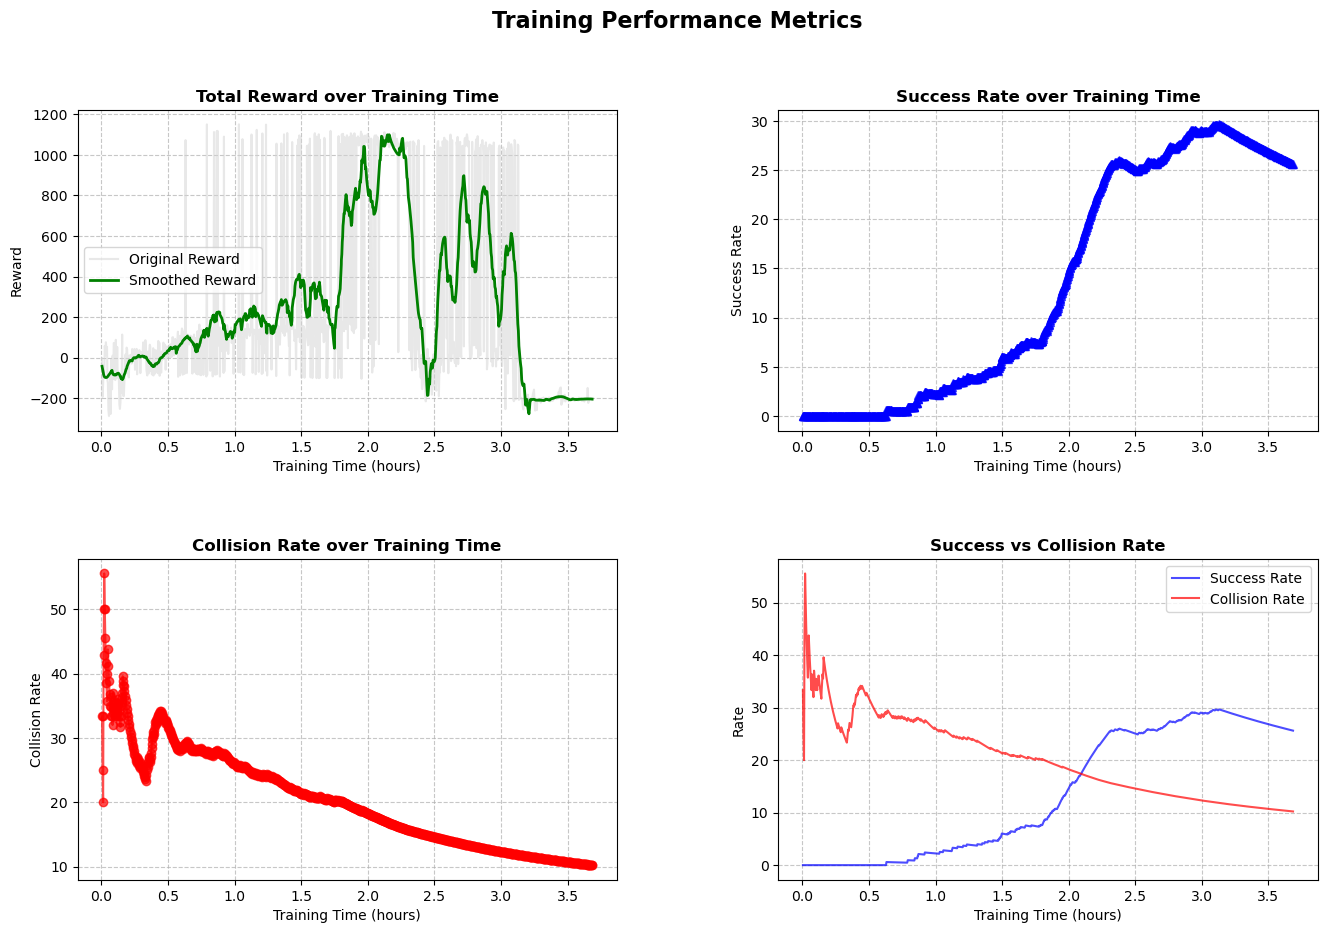

In [30]:
# Load the .npz file
loaded_data = np.load("./results/stats_TD3_64_64_0.npz")

# Access the individual arrays using their keys
rewards = loaded_data['Total_Reward']
success_rate = loaded_data['Success_Rate']
collision_rate = loaded_data['Collision_Rate']
training_time = loaded_data['Training_Time'] / 3600  # Convert to hours

# Create a figure with a more elegant layout
plt.figure(figsize=(16, 10))

# Smoothing parameters
window = 20  # Adjust this value to control smoothness
smoothing_method = 'savitzky_golay'

# Plot layout with GridSpec for more control
import matplotlib.gridspec as gridspec

gs = gridspec.GridSpec(2, 2, width_ratios=[1, 1], height_ratios=[1, 1])
plt.subplots_adjust(wspace=0.3, hspace=0.4)

# Reward Plot
plt.subplot(gs[0, 0])
plt.plot(training_time, rewards, label="Original Reward", color='lightgray', alpha=0.5)
plt.plot(training_time, smooth_data(rewards, window, smoothing_method), 
         label=f"Smoothed Reward", color='green', linewidth=2)
plt.title("Total Reward over Training Time", fontweight='bold')
plt.xlabel("Training Time (hours)")
plt.ylabel("Reward")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# Success Rate Plot
plt.subplot(gs[0, 1])
plt.plot(training_time, success_rate, label="Success Rate", color='blue', marker='^', alpha=0.7)
plt.title("Success Rate over Training Time", fontweight='bold')
plt.xlabel("Training Time (hours)")
plt.ylabel("Success Rate")
plt.grid(True, linestyle='--', alpha=0.7)

# Collision Rate Plot (New plot)
plt.subplot(gs[1, 0])
plt.plot(training_time, collision_rate, label="Collision Rate", color='red', marker='o', alpha=0.7)
plt.title("Collision Rate over Training Time", fontweight='bold')
plt.xlabel("Training Time (hours)")
plt.ylabel("Collision Rate")
plt.grid(True, linestyle='--', alpha=0.7)

# Overlay Metrics Plot
plt.subplot(gs[1, 1])
plt.plot(training_time, success_rate, label="Success Rate", color='blue', alpha=0.7)
plt.plot(training_time, collision_rate, label="Collision Rate", color='red', alpha=0.7)
plt.title("Success vs Collision Rate", fontweight='bold')
plt.xlabel("Training Time (hours)")
plt.ylabel("Rate")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# Add an overall title
plt.suptitle("Training Performance Metrics", fontsize=16, fontweight='bold')

# Show the plot
plt.show()